In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

## Data

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.


This dataset provides the customer information. It includes 41188 records and 21 fields. In this example, we use 10% of dataset

In [22]:
data = pd.read_csv('bank.csv', header=0, delimiter=';')
data = data.dropna()
print(data.shape)
print(list(data.columns))

(4521, 17)
['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']


In [23]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


#### Input variables

1 - age (numeric)

2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')

3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)

4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')

5 - default: has credit in default? (categorical: 'no','yes','unknown')

6 - housing: has housing loan? (categorical: 'no','yes','unknown')

7 - loan: has personal loan? (categorical: 'no','yes','unknown')

8 - contact: contact communication type (categorical: 'cellular','telephone')

9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')

10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')

11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

14 - previous: number of contacts performed before this campaign and for this client (numeric)

15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

16 - emp.var.rate: employment variation rate - (numeric)

17 - cons.price.idx: consumer price index - (numeric)

18 - cons.conf.idx: consumer confidence index - (numeric) 

19 - euribor3m: euribor 3 month rate - (numeric)

20 - nr.employed: number of employees - (numeric)

#### Predict variable (desired target):

y - has the client subscribed a term deposit? (binary: '1','0')

The education column of the dataset has many categories and we need to reduce the categories for a better modelling. The education column has the following categories:

In [14]:
data['education'].unique()

array(['primary', 'secondary', 'tertiary', 'unknown'], dtype=object)

In [33]:
data['job'].unique()

array(['unemployed', 'services', 'management', 'blue-collar',
       'self-employed', 'technician', 'entrepreneur', 'admin.', 'student',
       'housemaid', 'retired', 'unknown'], dtype=object)

### Data exploration

In [15]:
data['y'].value_counts()

no     4000
yes     521
Name: y, dtype: int64

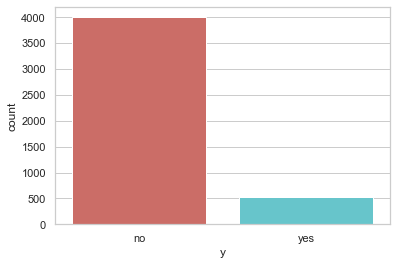

<Figure size 432x288 with 0 Axes>

In [16]:
sns.countplot(x='y',data=data, palette='hls')
plt.show()
plt.savefig('count_plot')

There are 4000 no's and 521 yes's in the outcome variables.

Let's get a sense of the numbers across the two classes

In [18]:
data.groupby('y').mean()

,age,balance,day,duration,campaign,pdays,previous
y,,,,,,,
no,40.998000,1403.211750,15.948750,226.347500,2.862250,36.006000,0.471250
yes,42.491363,1571.955854,15.658349,552.742802,2.266795,68.639155,1.090211


Observations:

The average age of customers who bought the term deposit is higher than that of the customers who didn't.
The pdays (days since the customer was last contacted) is understandably lower for the customers who bought it. The lower the pdays, the better the memory of the last call and hence the better chances of a sale.
Surprisingly, campaigns (number of contacts or calls made during the current campaign) are lower for customers who bought the term deposit.

We can calculate categorical means for other categorical variables such as education and marital status to get a more detailed sense of our data.

In [19]:
data.groupby('job').mean()

,age,balance,day,duration,campaign,pdays,previous
job,,,,,,,
admin.,39.682008,1226.736402,16.324268,234.669456,2.631799,49.993724,0.644351
blue-collar,40.156448,1085.161734,15.482030,278.161734,2.846723,41.590909,0.493658
entrepreneur,42.011905,1645.125000,15.255952,285.476190,2.589286,32.273810,0.428571
housemaid,47.339286,2083.803571,15.294643,292.633929,2.500000,26.401786,0.357143
management,40.540764,1766.928793,16.254902,260.536636,2.973168,40.968008,0.549020
retired,61.869565,2319.191304,15.556522,285.656522,2.465217,35.073913,0.591304
self-employed,41.453552,1392.409836,16.180328,264.125683,3.278689,28.256831,0.590164
services,38.570743,1103.956835,15.515588,262.486811,2.822542,36.371703,0.443645
student,26.821429,1543.821429,16.392857,248.690476,2.392857,45.714286,0.964286


In [20]:
data.groupby('marital').mean()

,age,balance,day,duration,campaign,pdays,previous
marital,,,,,,,
divorced,45.475379,1122.390152,15.753788,279.232955,2.604167,38.827652,0.439394
married,43.454415,1463.195567,15.905971,256.528781,2.847336,38.466929,0.519128
single,33.927258,1460.414716,16.008361,274.601171,2.751672,43.220736,0.642977


In [21]:
data.groupby('education').mean()

,age,balance,day,duration,campaign,pdays,previous
education,,,,,,,
primary,46.833333,1411.544248,15.505900,261.709440,2.865782,35.069322,0.460177
secondary,40.062446,1196.814397,15.977884,269.863833,2.734172,40.934085,0.528621
tertiary,39.645926,1775.423704,16.009630,256.881481,2.901481,39.824444,0.612593
unknown,45.299465,1701.245989,15.946524,250.449198,2.486631,41.983957,0.508021


Visualizations

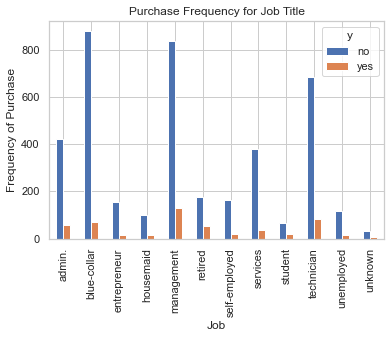

In [24]:
%matplotlib inline
pd.crosstab(data.job,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Job Title')
plt.xlabel('Job')
plt.ylabel('Frequency of Purchase')
plt.savefig('purchase_fre_job')

The frequency of purchase of the deposit depends a great deal on the job title. Thus, the job title can be a good predictor of the outcome variable.

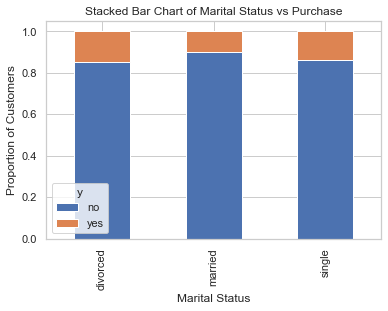

In [25]:
table=pd.crosstab(data.marital,data.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Marital Status vs Purchase')
plt.xlabel('Marital Status')
plt.ylabel('Proportion of Customers')
plt.savefig('mariral_vs_pur_stack')

Hard to see, but the marital status does not seem a strong predictor for the outcome variable.

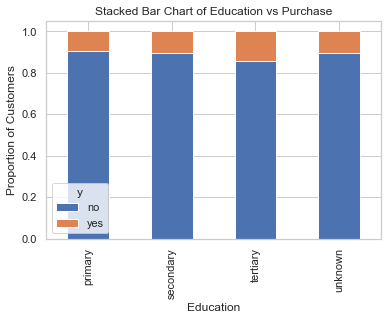

In [26]:
table=pd.crosstab(data.education,data.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Education vs Purchase')
plt.xlabel('Education')
plt.ylabel('Proportion of Customers')
plt.savefig('edu_vs_pur_stack')

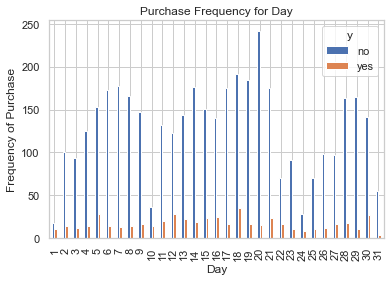

In [45]:
pd.crosstab(data.day,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Day')
plt.xlabel('Day')
plt.ylabel('Frequency of Purchase')
plt.savefig('pur_fre_day_bar')

Education seems a good predictor of the outcome variable.

Day of week may not be a good predictor of the outcome

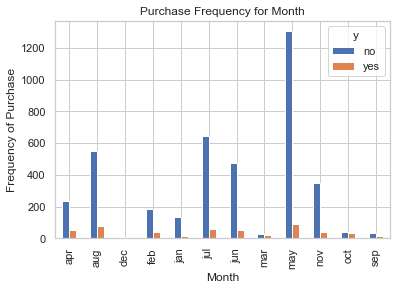

In [28]:
pd.crosstab(data.month,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Month')
plt.xlabel('Month')
plt.ylabel('Frequency of Purchase')
plt.savefig('pur_fre_month_bar')

Month might be a good predictor of the outcome variable

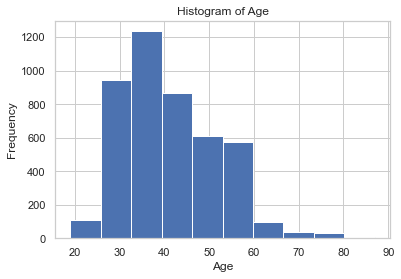

In [29]:
data.age.hist()
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.savefig('hist_age')

The most of the customers of the bank in this dataset are in the age range of 30-40.

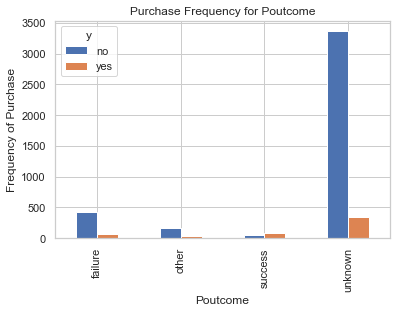

In [30]:
pd.crosstab(data.poutcome,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Poutcome')
plt.xlabel('Poutcome')
plt.ylabel('Frequency of Purchase')
plt.savefig('pur_fre_pout_bar')

Poutcome seems to be a good predictor of the outcome variable.

### Create dummy variables

In [35]:
data['job'].unique()

array(['unemployed', 'services', 'management', 'blue-collar',
       'self-employed', 'technician', 'entrepreneur', 'admin.', 'student',
       'housemaid', 'retired', 'unknown'], dtype=object)

In [46]:
cat_vars=['job','marital','education','default','housing','loan','contact','month','day','poutcome']
for var in cat_vars:
    cat_list='var'+'_'+ var
    cat_list = pd.get_dummies(data[var], prefix=var)
    data1=data.join(cat_list, lsuffix='_left')
    data=data1

In [47]:
cat_vars=['job','marital','education','default','housing','loan','contact','month','day','poutcome']
data_vars=data.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]

In [48]:
data_final=data[to_keep]
data_final.columns.values

array(['age', 'balance', 'duration', 'campaign', 'pdays', 'previous', 'y',
       'job_admin._left', 'job_admin._left', 'job_admin._left',
       'job_admin._left', 'job_blue-collar_left', 'job_blue-collar_left',
       'job_blue-collar_left', 'job_blue-collar_left',
       'job_entrepreneur_left', 'job_entrepreneur_left',
       'job_entrepreneur_left', 'job_entrepreneur_left',
       'job_housemaid_left', 'job_housemaid_left', 'job_housemaid_left',
       'job_housemaid_left', 'job_management_left', 'job_management_left',
       'job_management_left', 'job_management_left', 'job_retired_left',
       'job_retired_left', 'job_retired_left', 'job_retired_left',
       'job_self-employed_left', 'job_self-employed_left',
       'job_self-employed_left', 'job_self-employed_left',
       'job_services_left', 'job_services_left', 'job_services_left',
       'job_services_left', 'job_student_left', 'job_student_left',
       'job_student_left', 'job_student_left', 'job_technician_left',
    

In [51]:
data_final_vars=data_final.columns.values.tolist()
y=['y']
X=[i for i in data_final_vars if i not in y]

### Feature Selection

In [ ]:
#### Using feature selection 

In [53]:
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

# rfe = RFE(logreg, 18)
rfe = logreg.fit(data_final[X], data_final[y] )
# print(rfe.support_)
# print(rfe.ranking_)



/Users/andang/miniconda3/envs/MLcoban/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/andang/miniconda3/envs/MLcoban/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [55]:
cols=["previous", "job_blue-collar", "job_retired", "job_services", "job_student", "default_no", 
      "month_aug", "month_dec", "month_jul", "month_nov", "month_oct", "month_sep", 
      "poutcome_failure", "poutcome_success"] 
X=data_final[cols]
y=data_final['y']

### Logistic Regression Model Fitting

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

#### Predicting the test set results and caculating the accuracy

In [58]:
y_pred = logreg.predict(X_test)

In [59]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.89


### Cross Validation

In [60]:
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
kfold = model_selection.KFold(n_splits=10, random_state=7)
modelCV = LogisticRegression()
scoring = 'accuracy'
results = model_selection.cross_val_score(modelCV, X_train, y_train, cv=kfold, scoring=scoring)
print("10-fold cross validation average accuracy: %.3f" % (results.mean()))

/Users/andang/miniconda3/envs/MLcoban/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


10-fold cross validation average accuracy: 0.894


### Confusion Matrix

In [61]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[1181    9]
 [ 143   24]]


#### Accuracy

In [63]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.89


#### Compute precision, recall, F-measure and support

The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.

The F-beta score weights recall more than precision by a factor of beta. beta == 1.0 means recall and precision are equally important.

The support is the number of occurrences of each class in y_test.

In [64]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          no       0.89      0.99      0.94      1190
         yes       0.73      0.14      0.24       167

    accuracy                           0.89      1357
   macro avg       0.81      0.57      0.59      1357
weighted avg       0.87      0.89      0.85      1357



#### Interpretation: 

Of the entire test set, 88% of the promoted term deposit were the term deposit that the customers liked. Of the entire test set, 90% of the customer's preferred term deposit were promoted.

### ROC Curve from sklearn import metrics

In [70]:
y_test

4274    no
72      no
1065    no
3185    no
130     no
        ..
200     no
2663    no
4455    no
3059    no
2427    no
Name: y, Length: 1357, dtype: object

##### HOMEWORK: Fix BUG of drawing roc_curve

In [69]:
# Fix bug
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

ValueError: could not convert string to float: 'no'

### Apply Oversampling Method
##### from imblearn.over_sampling import SMOTE